In [1]:
from sena.data.norec_sentence.dataloader import load_binary_dataset
import sena.utils.utils as utils
import pandas as pd

In [2]:
data = load_binary_dataset()

train = data["train"]
val = data["dev"]
test = data["test"]

train = utils.clean_text(train, "text")
val = utils.clean_text(val, "text")
test = utils.clean_text(test, "text")

combined_data = pd.concat([train, val, test])

In [3]:
from collections import Counter
import math

num_words = Counter()
for review in combined_data["text"]:
    for word in review.split(" "):
        num_words[word] += 1

num_words = len(num_words)
num_words = math.ceil(num_words / 1000) * 1000
print("Number of words:", num_words)

Number of words: 18000


<AxesSubplot:>

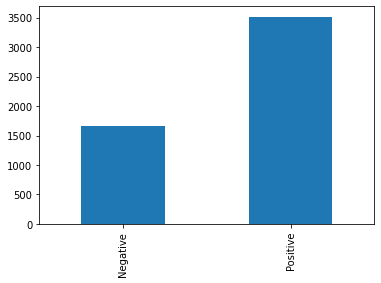

In [4]:
combined_data["label"].replace({0: "Negative", 1: "Positive"}).value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

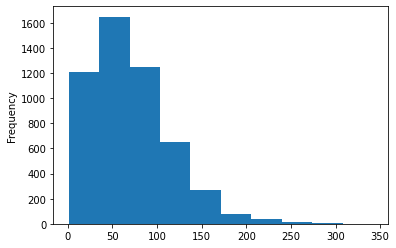

In [5]:
combined_data["text"].str.len().plot.hist()

In [6]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

X_train, y_train = train["text"], train["label"]
X_val, y_val = val["text"], val["label"]
X_test, y_test = test["text"], test["label"]

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(combined_data["text"])

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [7]:
from collections import Counter

combined_text = tokenizer.texts_to_sequences(combined_data["text"])

word_counter = Counter()
for review in combined_text:
    for word in review:
        word_counter[tokenizer.index_word[word]] += 1

In [8]:
word_counter.most_common(10)

[('litt', 200),
 ('godt', 178),
 ('gjør', 172),
 ('får', 163),
 ('the', 144),
 ('filmen', 143),
 ('helt', 139),
 ('nok', 134),
 ('to', 126),
 ('hele', 118)]

In [9]:
maxlen = 100
X_train = pad_sequences(X_train, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)
y_test = to_categorical(y_test, 2)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape, end="\n\n")
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape, end="\n\n")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3894, 100)
y_train shape: (3894, 2)

X_val shape: (701, 100)
y_val shape: (701, 2)

X_test shape: (583, 100)
y_test shape: (583, 2)


In [10]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.regularizers import l2

model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=128))
model.add(LSTM(units=128, dropout=0.3, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01),
               bias_regularizer=l2(0.01), return_sequences=True))
model.add(LSTM(units=128, dropout=0.3, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01),
               bias_regularizer=l2(0.01)))
model.add(Dense(units=2, activation='softmax'))

In [11]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2304000   
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 2,567,426
Trainable params: 2,567,426
Non-trainable params: 0
_________________________________________________________________


In [12]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", mode="max", patience=3)

epochs = 20
batch_size = 16
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1,
                    callbacks=[early_stop])

Epoch 1/20
244/244 [==============================] - 103s 346ms/step - loss: 3.4126 - accuracy: 0.6736 - val_loss: 2.1440 - val_accuracy: 0.6990
Epoch 2/20
244/244 [==============================] - 68s 280ms/step - loss: 1.7828 - accuracy: 0.6739 - val_loss: 1.4465 - val_accuracy: 0.6990
Epoch 3/20
244/244 [==============================] - 67s 274ms/step - loss: 1.1094 - accuracy: 0.8115 - val_loss: 1.1435 - val_accuracy: 0.6862
Epoch 4/20
244/244 [==============================] - 68s 278ms/step - loss: 0.5424 - accuracy: 0.9422 - val_loss: 1.1360 - val_accuracy: 0.6562


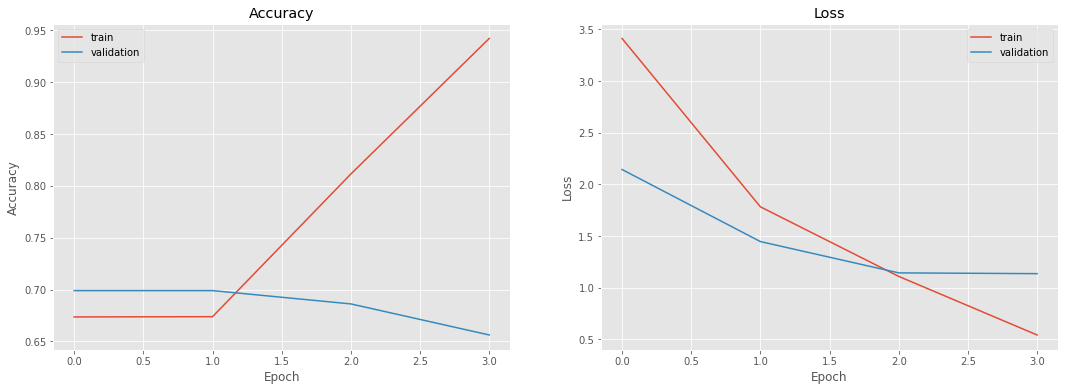

In [13]:
from sena.utils.utils import plot_history

plot_history(history)

In [14]:
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=1)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

19/19 [==============================] - 3s 129ms/step - loss: 1.0994 - accuracy: 0.6827
Validation loss: 1.0993722677230835
Validation accuracy: 0.682675838470459


In [15]:
from datetime import datetime

if val_acc > 0.8:
    model.save(f"models/SA-LSTM-BINARY-{datetime.now().strftime('%Y%m%d%H%M%S')}.h5")